# Label Sensitivity

*Code to create Figure 3f in [Saliency Cards: A Framework to Characterize and Compare
Saliency Methods](https://arxiv.org/abs/2206.02958).*

Saliency maps are computed with respect to a particular target label. Label sensitivity measures the saliency method's response to changes to that target label. 

To illustrate label sensitivity, we show how [SmoothGrad](https://arxiv.org/abs/1706.03825) reveals different parts of an image that are important to different model predictions.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import torch

from saliency_methods.util import visualize_saliency
from saliency_methods.vanilla_gradients import VanillaGradients
from util import imagenet_transform, imagenet_normalize, load_model_from_pytorch, load_pil_image

## Load ImageNet Image and ResNet50 Model
In this example we compute the saliency of a ResNet50 model pretrained on ImageNet.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_model_from_pytorch('resnet50', True, device).eval()

We select an image from ImageNet to evaluate.

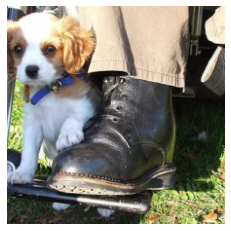

In [4]:
image_path = './resources/dog.jpeg'
image = load_pil_image(image_path)

model_transform = imagenet_transform(normalize=True)
display_transform = imagenet_transform(normalize=False)

image_input = model_transform(image)
display_input = display_transform(image).numpy()
display_batch = np.expand_dims(display_input, axis=0)
plt.imshow(display_input.transpose(1, 2, 0))
plt.axis('off');

## Get Top Model Predictions
To demonstrate label sensitivity, we show that [SmoothGrad](https://arxiv.org/abs/1706.03825) can identify different regions that contribute to different target classes. So, first, we determine what the model thinks the model likely classes for the image are.

In [5]:
input_batch = image_input.unsqueeze(0).to(device)
output = model(input_batch)
predictions = np.argsort(output.cpu().detach().numpy(), axis=1)[0]

In [6]:
with open('resources/imagenet_labels.json', 'r') as f:
    labels = json.load(f)
top_predictions = [i for i in predictions[::-1][:5]]
print(f'Top Predictions: {[labels[pred].lower() for pred in top_predictions]}')

Top Predictions: ['blenheim_spaniel', 'brittany_spaniel', 'papillon', 'welsh_springer_spaniel', 'cowboy_boot']


## Compute SmoothGrad Saliency Towards Different Classes
We apply [SmoothGrad](https://arxiv.org/abs/1706.03825) to the `blenheim_spaniel` and `cowboy_boot` classes, showing that it is label sensitive because it reflects changes in the saliency.

In [7]:
image_batch = image_input.unsqueeze(0).to(device)

In [8]:
vg = VanillaGradients(model)

/nobackup/users/aboggust/bin/miniconda3/envs/wml/lib/python3.6/site-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


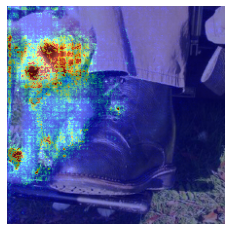

In [9]:
blenheim_spaniel_class = int(top_predictions[0])
blenheim_spaniel_saliency = vg.get_saliency_smoothed(image_batch, target_classes=[blenheim_spaniel_class])
visualize_saliency(blenheim_spaniel_saliency, images=display_batch, scheme='heatmap', image_cmap='gray');

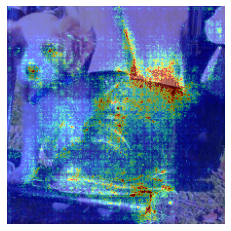

In [10]:
cowboy_boot_class = int(top_predictions[4])
cowboy_boot_saliency = vg.get_saliency_smoothed(image_batch, target_classes=[cowboy_boot_class])
visualize_saliency(cowboy_boot_saliency, images=display_batch, scheme='heatmap', image_cmap='gray');